In [1]:
%matplotlib inline

# Combining Different Models for Ensemble Learning.

In this chapter we will learn how to do the following:

- Make predictions based on majority voting.
- Use bagging to reduce overfitting by drawing random combinations of the training set with repetition.
- Apply boosting to build powerful models from weak learners that learn from their mistakes.

## Learning with ensembles
The goal of ensemble methods is to combine different classifiers into a meta-classifier that has better generalisation performance than each individual classifier alone.

In this chapter, we will focus on the most popular ensemble methods that use the **majority voting** principle.  Majority voting simply means that we select the class label that has been predicted by the majority of classifiers, that is, received more than 50% of the votes.

In plurality voting, we select the class label that received the most votes (mode).

The following diagram illustrates the concept of majority and plurality voting for an ensemble of 10 classifiers where each unique symbol (triangle, square, and circle) represents a unique class label:

<img src="images/07_01.png" alt="Majority_Voting" style="width: 500px;"/>

Using the training set, we start by training $m$ different classifiers $\left(C_1, C_2, \ldots, C_m  \right)$.  Depending on the technique, the ensemble can be built from different classification algorithms, for example, decision trees, support vector machines, logistic regression classifiers, and so on.

Alternatively, we can also use the same base classification algorithm, fitting different subsets of the training set.  One prominent example of this approach is the random forest algorithm, which combines different decisition tree classifiers.  The following figure illustrates the concept of a general ensemble approach using majority voting:

<img src="images/07_02.png" alt="Ensemble_Approach" style="width: 500px;"/>

To predict a class label via simple majority or plurality voting, we combine the predicted class labels of each individual classifier, $C_j$, and select the class label, $\hat{y}$, that received the most votes:

$$
\hat{y} = mode\left\{ C_1(\mathbf{x}), C_2(\mathbf{x}),\ldots , C_m(\mathbf{x}) \right\}
$$

For example, in a binary classification task where $class1 = -1$ and $class2 = +1$, we can write the majority bote prediction as follows:

$$
C(\mathbf{x}) = sign\left[ \sum_{j=1}^{m}C_j(\mathbf{x}) \right] = \left\{
    \begin{array}{rl}
        {1} & \mbox{if } \sum_jC_j(\mathbf{x}) \geq 0 \\
        {-1} & \mbox{otherwise}
    \end{array}
\right.
$$

To illustrate why ensemble methods can work better than individual classifiers alone, let's apply the simple concepts of combinatorics.  For the following example, we make the assumption that
1. All $n$-base classifiers for a binary classification task have an equal error rate, $\epsilon$.
2. All classifiers are independent.
3. All the error rates are not correlated.
Under these assumptions, we can simply express the error probability of an ensemble of base classifiers as a _probability mass function of a binomial distribution_:
$$
P(y\geq k) = \sum_{k}^{n} \binom{n}{k}\epsilon^k(1 - \epsilon)^{n-k} = \epsilon_{ensemble}
$$

Here, $\binom{n}{k}$ is the binomial coefficient **n choose k**.  In other words, we compute the probability that the prediction of the ensemble is wrong.  Now let's take a look at a more concrete example of 11 base classifiers ($n=11$), where each classifier has an error rate of 0.25 $(\epsilon = 0.25)$:

$$
P(y\geq k) = \sum_{6}^{11} \binom{11}{k}0.25^k(1 - 0.25)^{11-k} = 0.034
$$

Let us implement the probability mass function in Python:

In [2]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k * (1 - error)**(n_classifier - k) 
            for k in range(k_start, n_classifier + 1)]
    return sum(probs)

print(ensemble_error(n_classifier=11, error=0.25))

0.03432750701904297


After we have implemented the ```ensemble_error``` function, we can compute the ensemble error rates for a range of different base errors from 0.0 to 1.0 to visualise the relationship between ensemble and basee errors in a line graph:

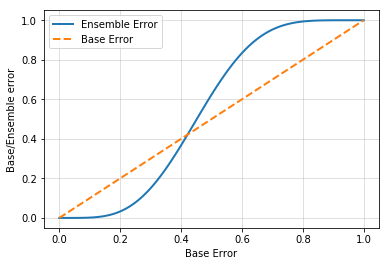

In [3]:
import numpy as np
import matplotlib.pyplot as plt
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=10, error=error) for error in error_range]

plt.plot(error_range, ens_errors, label="Ensemble Error", linewidth=2)
plt.plot(error_range, error_range, linestyle="--", label="Base Error", linewidth=2)
plt.xlabel("Base Error")
plt.ylabel("Base/Ensemble error")
plt.legend(loc="upper left")
plt.grid(alpha=0.5)
plt.show()

As we can see in the resulting plot, the error probability of an ensemble is always better than the error of an individual base classifier, as long as the base classifiers perform better than random guessing $\left( \epsilon < 0.5 \right)$.  Notice that the $y$-axis depcits the base error (dotted line), as well as the ensemble error (continuous line).

## Implementig a simple majority vote classifier:
Our goal is to build a stronger meta-classifier that balances out the individual classifier's weaknessees on a particular dataset.  In more precise mathematical  terms, we can write the weighted majority vote as follows:

$$
\hat{y} = \mbox{arg max}_i\sum_{j=1}^{m}w_j\chi_A\left( C_j(\mathbf{x}) = i \right)
$$
Here, $w_j$ is a weight associated with a base classifier, $C_j$, $\hat{y}$ is the predicted class label of the ensemble, $\chi_A$ is the characteristic function $\left[ C_j(\mathbf{x}) = i \in A \right]$, and $A$ is the set of unique class labels.  For equal weights, we can simplify this equation and write it as follows:

$$
\hat{y} = mode\left\{ C_1(\mathbf{x}), C_2(\mathbf{x}),\ldots , C_m(\mathbf{x}) \right\}
$$

To translate the concept of the weighted majority vote into Python code, we can use NumPy's convenient ```argmax``` and ```bincount``` functions:

In [4]:
import numpy as np
print(np.argmax(np.bincount([0,0,1], weights=[0.2,0.2,0.6])))

1


Using predicted class probabilities instead of the class labels for majority voting can be useful if the classifiers in our ensemble are well calirated.  The modified version of the majority vote for predicting class labels from probabilities can be written as follows:
$$
\hat{y} = \mbox{arg max}_i\sum_{j=1}^{m}w_jp_{ij}
$$

Here, $p_{ij}$ is the predicted probability of the $j$th classifier for the class label $i$.

To implement the weighted majority vote based on class probabilities, we can again make use of NumPy's average and argmax functions.

In [5]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2,0.2,0.6])
print(p)
print(np.argmax(p))

[0.58 0.42]
0


Putting everything together, let's now implement ```MajorityVoteClassifier``` in Python:

In [6]:
from sklearn.base import BaseEstimator  # The base class for all estimators in scikit-learn.
from sklearn.base import ClassifierMixin  # Mixin class for all classifiers in scikit-learn.
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone  # Constructs a new estimator with the same parameters.
#  Clone does a deep copy of the model in an estimator without actually copying attached data.
#  It yields a new estimator with the same parameters that has not been fit on any data.
from sklearn.pipeline import _name_estimators
import numpy as np
import operator  # exports a set of efficient functions corresponding to the intrinsic operators of Python.
#  For example, operator.add(x, y) is equivalent to the expression x+y.

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    A majority vote ensemble classifier.
    
    We imported the BaseEstimator and ClassifierMixin parent classes to get some base functionality for free,
    including the get_params and set_parms methods to set and return the classifier's parameters,
    as well as the score method to calculate the prediction accuracy.
    Also note that we imported six to make MajorityVoteClassifier compatible with Python 2.6.
    
    We will also add the predict method to predict the class label via a majority vote based on the class labels,
    if we initialise a new MajorityVoteClassifier object with vote='classlabel'.
    Alternatively, we will be able to initialise the ensemble classifier with vote='probability', to predict the
    class label on the class membership probabilities.
    Furthermore, we will also add a predict_proba method to return the averaged probabilities,
    which is useful when computing the ROC AUC.
    
    Parameters:
    -----------
    classifiers: array-like
        shape = [n_classifiers]
        The Different classifiers for the ensemble.
    
    vote: str, {'classlabel', 'probability'}
        Default: 'classlabel'
        If 'classlabel' the prediction is based on the argmax of class labels.
        
        Else if 'probability', the argmax of the sum of probabilities is used to predict the class label
        (this is recommended for calibrated classifiers)
    
    weights: array-like
        shape = [n_classifiers]
        Optional, default: None
        If a list of `int` or `float` values are provided,
        the classifiers are weighted by importance.
        
        It uses uniform weights if `weights=None`.
    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key:value for (key, value) in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        Fit the classifiers.
        
        Parameters:
        -----------
        X: {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of the training samples.
        
        y: array-like
            shape = [n_samples]
            Vector of target class labels.
        
        Returns:
        --------
        self: object
        """
        
        # Use LabelEncoder to ensure class labels start with 0,
        # which is important for np.argmax call in self.predict.
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []  # list of fitted classifiers trained on transformed class labels.
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        Predict the class labels for X.
        
        Parameters:
        -----------
        X: {array_like, sparse matrix},
            shape = [n_samples, n_features]
            Matrix of training samples.
        
        Returns:
        --------
        maj_vote: array-like
            shape = [n_samples]
            Returns the predicted class labels.
        """
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
            
        else:  # 'classlabel'=vote.  Collect the results from the clf.predict class.
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            
            # Apply a function to 1-D slices along the given axis.
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)),
                                          axis=1,
                                          arr=predictions)
            
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        Predict the class probabilities for X.
        
        Parameters:
        -----------
        X: {array-like, sparse matrix},
            shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples, 
            and n_features is the number of features.
        
        Returns:
        --------
        avg_proba: array-like
            shape = [n_samples, n_classes]
            Returns the weighted average probability for each class per sample.
        """
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """
        Get the classifier parameter names for GridSearch.
        """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out["{:s}__{:s}".format(name, key)] = value
            return out

## Using the majority voting principle to make predictions

We take a shortcut and load the Iris dataset from sciki-learn's dataset module.  Furthermore, we will only select 2 features **sepal width and petal length**, to make the classification task more challenging for illustration purposes.

We will only classify flower samples from the ```Iris-versicolor``` and ```Iris-virginica```, with which we will compute the ROC AUC later on.  The code is as follows:

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn .preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:,[1,2]], iris.target[50:]
le = LabelEncoder()
print("y before fit_transform of label-encoder:\n{}".format(y))
y = le.fit_transform(y)
print("\ny after fit_transform of label-endcoder:\n{}".format(y))

y before fit_transform of label-encoder:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]

y after fit_transform of label-endcoder:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Next, we split the Iris samples into 50% training and 50% test data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.5,
                                                   random_state=1,
                                                   stratify=y)

Using the training dataset, we now will train three different classifiers:

- Logistic Regression Classifier
- Decision Tree Classifier
- K-Nearest Neighbor Classifier

We then evaluate the model performance of each classifier via 10-fold cross-validation on the training dataset before we combine them into an ensemble classifier:

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty="l2",
                         C=0.001,
                         random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                             criterion="entropy",
                             random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                           p=2,
                           metric="minkowski")
pipe1 = Pipeline([["sc", StandardScaler()],
                  ["clf", clf1]])
pipe3 = Pipeline([["sc", StandardScaler()],
                  ["clf", clf3]])
clf_labels = ["Logistic regression", "Decision Tree", "KNN"]
print("10-fold cross validation:\n")
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring="roc_auc")
    print("ROC_AUC: {:.2f} (+/- {:.2f}) [{:s}]".format(scores.mean(), scores.std(), label))

10-fold cross validation:

ROC_AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC_AUC: 0.89 (+/- 0.16) [Decision Tree]
ROC_AUC: 0.88 (+/- 0.15) [KNN]


The output that we recieve shows that the predictive performances of the individual classifiers are almost equal.

Both the logistic regression and k-nearest neighbors algorithms (using the Euclidean distance metric) are not scale-invariant, in contrast to decision trees.  Although the Iris features are all measured on the same scale (cm), it is a good habit to work with standardised features.

Now let us move on to the more exciting part and combine the individual classifiers for majority rule voting in our ```MajorityVoteClassifier```:

In [10]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ["Majority Voting"]
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label, in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring="roc_auc")
    print("ROC_AUC: {:.2f} (+/- {:.2f}) [{:s}]".format(scores.mean(), scores.std(), label))

ROC_AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC_AUC: 0.89 (+/- 0.16) [Decision Tree]
ROC_AUC: 0.88 (+/- 0.15) [KNN]
ROC_AUC: 0.94 (+/- 0.13) [Majority Voting]


As we can see, the performance of ```MajorityBotingClassifier``` has improved over the individual classifiers in the 10-fold cross-validation evaluation.

## Evaluating and tuning the ensemble classifier

In this section, we are going to compute the ROC curves from the test test to check that ```MajorityVoteClassifier``` generalises well with unseen data. We shall remember that the test set is not to be used for model selection; its purpose is merely to report an unbiased estimate of the generalisation performance of the classifer system:

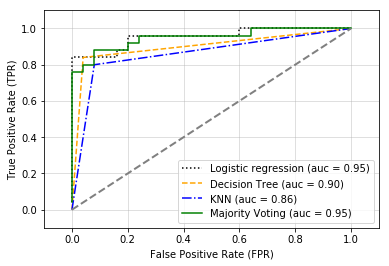

In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [":", "--", "-.", "-"]

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls,
            label="{:s} (auc = {:.2f})".format(label, roc_auc))
    
plt.legend(loc="lower right")
plt.plot([0,1],[0,1], linestyle="--", color="gray", linewidth=2)  # Random Guessing
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.show()

As we can see in the resulting ROC, the ensemble classifier also performs well on the test set (ROC_AUC = 0.95).  However, we can see that the logistic regression classifier performs similarly well on the same dataset, which is probably due to the high variance (in this case, sensitivity of how we split the dataset) given the small size of the dataset.

Since we only selected 2 features for the classification examples, it would be interesting to see what the decision region of the ensemble classifier actually looks like.  Although it is not necessary to standardise the traiing features prior to model fitting, because our logistic regression and k-nearest neighbors pipelines will automatically take care of it, we will standardise the training set so that the decision regions of the decision tree will be on the same scale for visual purposes.  The code is as follows:

/home/henri/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


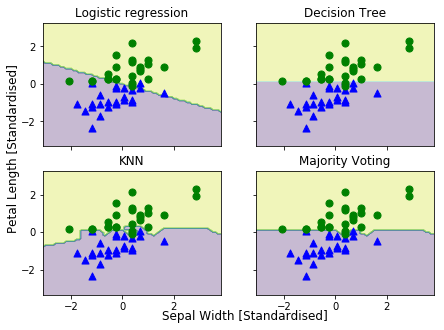

In [12]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

x_min = X_train_std[:,0].min() - 1
x_max = X_train_std[:,0].max() + 1
y_min = X_train_std[:,1].min() - 1
y_max = X_train_std[:,1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex="col", sharey="row", figsize=(7,5))

for idx, clf, tt in zip(product([0,1],[0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1],
                                 c="blue", marker="^", s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1],
                                 c="green", marker="o", s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, s="Sepal Width [Standardised]", ha="center", va="center", fontsize=12)
plt.text(-12.5, 4.5, s="Petal Length [Standardised]", ha="center", va="center", fontsize=12, rotation=90)
plt.show()

Before we tune the individual classifier's parameters for ensemble classification, let's call the ```get_params``` method to get a basic idea of how we can access the individual parameters inside a ```GridSearch``` object:

In [13]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

Based on the values returned by the ```get_params``` method, we now know how to access the individual classifier's attributes.  Let's now tune the inverse regularisation parameter C of the logistic regression classifier and the decision tree depth via a grid search for demonstration purposes:

In [14]:
from sklearn.model_selection import GridSearchCV
params = {"decisiontreeclassifier__max_depth": [1, 2, 3, 4, 5],
          "pipeline-1__clf__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(estimator=mv_clf,
                   param_grid=params,
                   cv=10,
                   scoring="roc_auc",
                   n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5], 'pipeline-1__clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

After the grid search has completed, we can print the different hyperparameter value combinations and the average ROC_AUC scores computed via the 10-fold cross-validation as follows:

In [15]:
for params, mean_score, scores in grid.grid_scores_:
    print("{:.3f} (+/- {:.3f}) {}".format(mean_score, scores.std()/2, params))

0.933 (+/- 0.067) {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 (+/- 0.067) {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.01}
0.947 (+/- 0.067) {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 (+/- 0.033) {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 1}
0.973 (+/- 0.033) {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 10}
0.973 (+/- 0.033) {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.973 (+/- 0.033) {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 1000}
0.947 (+/- 0.067) {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 (+/- 0.067) {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.01}
0.947 (+/- 0.067) {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 (+/- 0.033) {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 1}
0.973 (+/- 0.033) {'decisiontreeclassifier__max_dept

/home/henri/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


As we can see, we get the best cross-validation results when we choose lower regularisation strength (C=100), whereas the tree depth does not seem to affect the performance at all, suggesting that a decision stump is sufficient to separate the data.  To remind ourselves that is is a bad practice to use the test dataset more than once for model evaluation, we are not going to estimate the generalisation performance of the tuned hyperparameters in this section.  We will move on swiftly to an alternative approach for ensemble learning: **bagging**.

## Bagging - building an ensemble of classifiers from bootstrap samples

Bagging is an ensemble learning technique that is closely related to the ```MajorityVoteClassifier``` that we implemented in the previous section.  However, instead of using the same training set to fit the individual classifiers in the ensemble, we draw bootstrap samples (random samples with replacement) from the initial training set, which is why bagging is also known as bootstrap aggregating.

The concept of bagging is summarised in the following diagram:
<img src="images/07_06.png" style="width: 500px;"/>

In the following subsections, we will work through a simple example of bagging y hand and use scikit-learn for classifying wine samples.

### Bagging in a nuthsell

To provide more concrete example of how the bootstrapping aggregating of a bagging classifier works, let's consider the example shown in the following figure.  Here we have 7 different training instances (denoted as indices 1-7) that are sampled randomly with replacement in each round of bagging.  Each bootstrap sample is then used to fit a classifier $C_j$, which is most typically an unpruned decision tree:

<img src="images/07_07.png" style="width: 500px;"/>

As we can see from the previous illustration, each classifier receives a random subset of samples from the training set.  Each subset contains a certain portion of duplicates and some of the original samples don't appear in a resampled dataset at all due to sampling with replacement.  Once the individual classifier are fit to the bootstrap samples, the predictions are combined using majority voting.

Note that bagging is also related to the random forest classifier that we introduced in Chapter 3.  In face, random forests are a special case of bagging where we also use random feature subsets when fitting the individual decision trees.

### Applying bagging to classify samples in the Wine dataset

To see bagging in action, let's create a more complex classification problem using the Wine dataset that we introuced in Chapter 4.  Here, we will only consider the Wine classes 2 and 3, and we select 2 features: ```Alcohol``` and ```OD280/OD315 of diluted wines```:

In [16]:
import pandas as pd
df_wine = pd.read_csv("wine.data", header=None)
df_wine.columns = ["Class label", "Alcohol", "Malic Acid", "Ash", "Alcalinity of Ash",
                   "Magnesium", "Total Phenols", "Flavanoids", "Nonflavanoid phenols",
                   "Proanthocyanins", "Color Intensity", "Hue", "OD280/OD315 of diluted wines",
                   "Proline"]
# drop 1 class
df_wine = df_wine[df_wine["Class label"] != 1]
y = df_wine["Class label"].values
X = df_wine[["Alcohol", "OD280/OD315 of diluted wines"]].values

Next, we encode the class labels into a binary format and split the dataset into 80% training and 20% test sets, respectively:

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=1,
                                                   stratify=y)

A ```BaggingClassifier``` algorithm is already implemented in scikit-learn, which we can import from the ```ensemble``` submodule.  Here, we will use an unpruned decision tree as the base classifier and create an ensemble of 500 decition trees fit on different bootstrap samples of the training dataset.

In [18]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion="entropy",
                             random_state=1,
                             max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)

Next, we will calculate the accuracy score of the predition on the training and test dataset to compare the performance of the bagging classifier to the performance of a single unpruned decision tree:

In [19]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print("Decision Tree train/test accuracies: {:.3f}/{:.3f}".format(tree_train, tree_test))

Decision Tree train/test accuracies: 1.000/0.833


Based on the accuracy values that we printed here, the unpruned decision tree predicts all the class labels of the training samples correctly; however, the substantially lower test accuracy indicates high variance (overfitting) of the model:

In [20]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print("Bagging train/test accuracies: {:.3f}/{:.3f}".format(bag_train, bag_test))

Bagging train/test accuracies: 1.000/0.917


Although the training accuracies of the decision tree and bagging classifier are similar on the training set (both 100%), we can see that the bagging classifier has a slightly better generalisation performance as estimated on the test set.  Next, let's compare the decision regions between the decision tree and the bagging classifier:

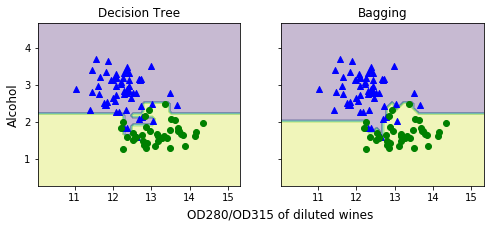

In [21]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

fig, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey="row", figsize=(8,3))

for idx, clf, tt in zip([0,1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1],
                      c='blue', marker="^")
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1],
                      c="green", marker="o")
    axarr[idx].set_title(tt)
axarr[0].set_ylabel("Alcohol", fontsize=12)
axarr[1].text(10, -0.5, s="OD280/OD315 of diluted wines", ha="center", va="center",
        fontsize=12)
plt.show()

As we can see in the resulting plot, the piece-wise linear decision boundary of the tree-node deep decision tree looks smoother in the bagging ensemble.

We only looked at a very simple bagging example in this section.  In practice, more complex classifcation tasks and a dataset's high dimensionality can easily lead to overfitting in single decision trees, and this is where the bagging algorithms can really play to its strengths.  Finally, we shall note that the bagging algorithm can be an effective approach to reduce the variance of a model.  However, bagging is ineffective in reducing model bias, that is, models that are too simple to capture the trend in the data well.  This is why we want to perform bagging on an ensemble of classifiers with low bias, for example, unpruned decision trees.

## Leveraging weak learners via adaptive boosting

In this last section about ensemble methods, we will discuss boosting with a special focus on its most common implementation, AdaBoost (Adaptive Boosting).

In bossting, the ensemble consists of very simple base classifiers, also often referred to as weak learners, which often only have a slight performance advantage over random guessing -- a typical example of a weak learner is a decision tree stump.  The key concept behind boosting is to focus on training samples that are hard to classify; that is, to let the weak learners subsequently learn from misclassified training samples to improve the performance of the ensemble.

The following subsections will introduce the algorithmic procedure behind the general concep tof boosting and a popular variant called AdaBoost.  Lastly, we will use sciki-learn for a practical classification example.

## How boosting works

In contrast to bagging, the initial formulation of boosting, the algorithm uses random subsets of training samples drawn from the training dataset **without replacement**; the original procedure is summarised in the following four key steps:

1. Draw a random subset of training samples $d_1$, without replacement from the training set $D$ to train a weak learner $C_1$.
2. Draw a second random training subset $d_2$, without replacement from the training set and add 50 percent of the samples that were previously misclassified to train a weak learner $C_2$.
3. Find the training samples $d_3$ in the training set $D$, which $C_1$ and $C_2$ disagree upon, to train a thrid weak learner $C_3$.
4. Combine the weak learners $C_1$, $C_2$, and $C_3$ via majority voting.

In practice, boosting algorithms such as AdaBoost are also known for their high variance, that is, the tendency to overfit the training data.

In contrast to the original boosting procedure as described here, AdaBoost uses the complete training set to train the weak learners where the training samples are reweighted in each iteration to build a strong classifier that learns from the mistakes of the previous weak learners in the ensemble.  The following figure illustrates the basic concept behind AdaBoost:

<img src="images/07_09.png" style="width: 500px;"/>

Now let's take a detailed look at the algorithm by using pseudocode.  For clarity, we will denote element-wise multiplication by the cross symbol $(\times)$ and the dot-product between two vectors by a dot symbol $(\cdot)$:
1. Set the weight vector \mathbf{w} to uniform weights, where $\sum_{i}w_i = 1$.
2. For $j$ in $m$ boosting rounds, do the following:
    1. Train a weighted weak learner:  $C_j = train(\mathbf{X},\mathbf{y},\mathbf{w})$.
    2. Predict the class labels: $\hat{y} = predict(C_j, \mathbf{X})$
    3. Compute the weighted error rate:  $\varepsilon = \mathbf{W}\cdot(\hat{\mathbf{y}}\neq\mathbf{y})$.
    4. Compute the coefficient:  $\alpha_j = 0.5\ln\frac{1 - \varepsilon}{\varepsilon}$.
    5. Update the weights: $\mathbf{w} := \mathbf{w}\times\mathrm{exp}(-\alpha_j\times\hat{\mathbf{y}}\times\mathbf{y})$.
    6. Normalise the wiehgts to sum to 1:  $\mathbf{w} := \frac{\mathbf{w}}{\sum_i w_i}$.
3. Compute the final prediction:  $\hat{\mathbf{y}} = \left( \sum_{j=1}^{m}(\alpha_j\times predict(C_j, \mathbf{X})) > 0 \right)$.

Note that the expression $(\hat{\mathbf{y}} \neq \mathbf{y})$ refers to a binary vector consisting of 1s and 0s, were a 1 is assigned if the prediction is incorrect and 0 is assigned otherwise.

### Applying AdaBoost using scikit-learn
Let us now train an AdaBoos ensemble classifier via scikit-learn.  We wil use the same Wine subset that we used in the previous section to train the bagging meta-classifier.  Via the ```base_estimator``` attribute, we will train the ```AdaBoostClassifier``` on 500 decision tree stumps:

In [23]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion="entropy",
                              random_state=1,
                              max_depth=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_predict = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print("Decision tree train/test accuracies {:.3f}/{:.3f}.".format(tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print("AdaBoost train/test accuracies {:.3f}/{:.3f}.".format(ada_train, ada_test))

Decision tree train/test accuracies 0.916/0.917.
AdaBoost train/test accuracies 1.000/0.917.


As we can see, the AdaBoost model predicts all the class labels of the training set correctly and also shows a slightly improved test set performance compared to the decision tree sumpt.  However, we also see that we introduced additional variance by our attempt to reduce the model bias -- a higher gap between training and test performance.

Remember it is considered bad practice to select a model based on the repeated usage of the test set.  The estimate of the generalisation performance may be over-optimistic, which we discussed in more detail in Chapter 6.

Lastly, let us check what the decision regions look like:

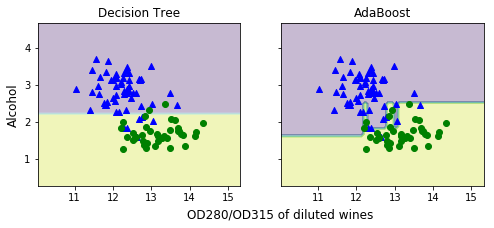

In [27]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1,2,sharex="col",sharey="row",figsize=(8,3))

for idx, clf, tt in zip([0,1], [tree, ada], ['Decision Tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0,0], X_train[y_train==0,1],
                       c="blue", marker="^")
    axarr[idx].scatter(X_train[y_train==1,0], X_train[y_train==1,1],
                       c="green", marker="o")
    axarr[idx].set_title(tt)
    axarr[0].set_ylabel("Alcohol", fontsize=12)
axarr[1].text(10, -0.5, s="OD280/OD315 of diluted wines",
              ha="center", va="center", fontsize=12)
plt.show()

By looking at the decision regions, we can see that the decision boundary of the AdaBoost model is substantially more complex than the decision boundary of the decision stump.  In addition, we note that the AdaBoost model separates the feature space very similarly to the bagging classifier that we trained in the previous section.

As concluding remarks about ensemble techniques, it is worth noting that ensemble learning increases the computational complexity compared to individual classifiers.  In practice, we need to think carefully about whether we want to pay the price of increased computational costs for an often reltively modest improvement in predictive performance.

## Summary

In this chapter, we looked at some of the most popular and widely used techinques for ensemble learning.  Ensemble methods combine different classification models to cancel out their individual weaknesses, which often results in stable and well-performing models.

Bagging is a useful technique to reduce the variance of a model by drawing random bootstrap samples from the training set and combining the individually trained classifiers via majority bote.  Lastly, we learned about AdaBoost, which is an algorithm that is based on weak learners that subsequently learn from their mistakes.

Throughout the previous chapters, we learned a lot about different learning algorithms, tuning, and evaluation techaniques.  In the next chapter, we will look at a particualr application of machine learning, sentiment analysis, which has become an interesting topic in the internet and social media era.